## Import Libraries

In [77]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [78]:
IMAGE_PATH = "Screenshot 2024-11-27 181534.png"
IMAGE_PATH_2 = 'Screenshot 2024-11-27 152657.png'

## A) Image Color 

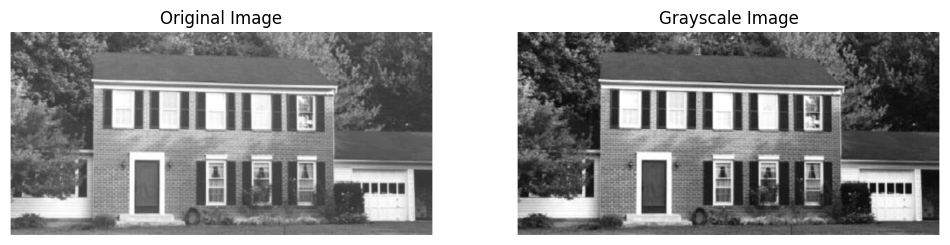

In [79]:
def Gray_scale(image_path):
    
    # convert it to grayscale
    img = Image.open(image_path).convert('L')
    return img


# Open the original image
org_image = Image.open(IMAGE_PATH)

# Function Call
gray_img = Gray_scale(IMAGE_PATH)

# Display the original and grayscale images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(org_image)
plt.title("Original Image")
plt.axis("off")

# Grayscale image
plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

# Show the images
plt.show()



## B)Threshold & Apply_threshold

Calculated Threshold: 127.66534104276381


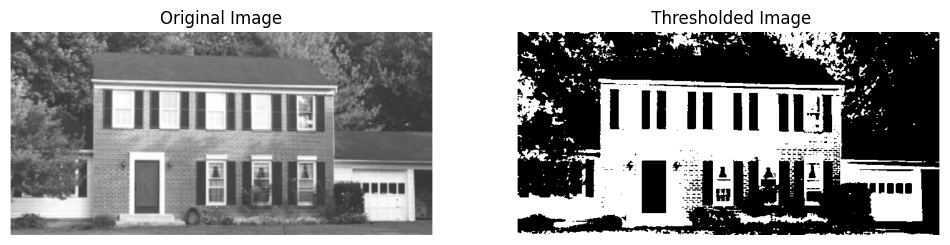

In [80]:
def calculate_threshold(image_path):
    
    # convert image to grayscale
    img = Image.open(image_path).convert('L')
    
    # Convert the image to a numpy array for calculation
    img_array = np.array(img)
    
    # Calculate the average pixel value
    avg_pixel_value = np.mean(img_array)
    
    # Use the average value as the threshold
    threshold = avg_pixel_value
    
    return threshold

def apply_threshold(image_path, threshold):
    
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    # Apply the threshold: 0 for pixels below the threshold, 255 for pixels above
    binary_image = np.where(img_array > threshold, 255, 0).astype(np.uint8)
    
    return Image.fromarray(binary_image)

# Calculate the threshold based on average pixel value
threshold = calculate_threshold(IMAGE_PATH)
print(f"Calculated Threshold: {threshold}")

# Apply the calculated threshold
binary_img = apply_threshold(IMAGE_PATH, threshold)

# Display the original and binary images side by side
original_img = Image.open(IMAGE_PATH)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Thresholded binary image
plt.subplot(1, 2, 2)
plt.imshow(binary_img, cmap="gray")
plt.title(" Thresholded Image")
plt.axis("off")

plt.show()


## C)Halftone

## 1)Simple Halftoning

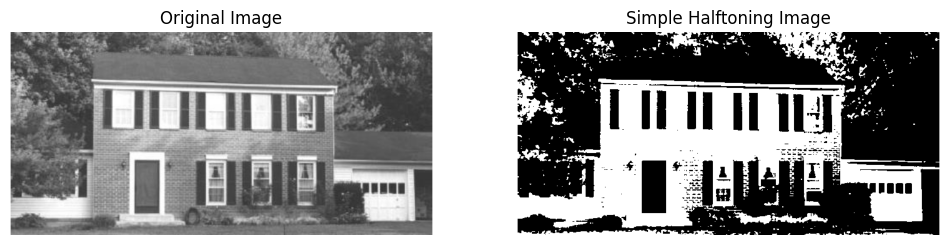

In [81]:
def simple_halftoning(image_path, threshold=128):
    
    # Open the image and convert it to grayscale
    img = Image.open(image_path).convert('L')

    # Convert image to a NumPy array
    img_array = np.array(img)

    # Apply thresholding
    binary_array = (img_array >= threshold).astype(np.uint8) * 255

    # Convert back to an image
    halftoned_image = Image.fromarray(binary_array)

    return halftoned_image


# Apply simple halftoning
halftoned_img = simple_halftoning(IMAGE_PATH, threshold=128)


# Display the original and binary images side by side
original_img = Image.open(IMAGE_PATH)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Thresholded binary image
plt.subplot(1, 2, 2)
plt.imshow(binary_img, cmap="gray")
plt.title("Simple Halftoning Image")
plt.axis("off")

plt.show()

## 2) Error Diffusion

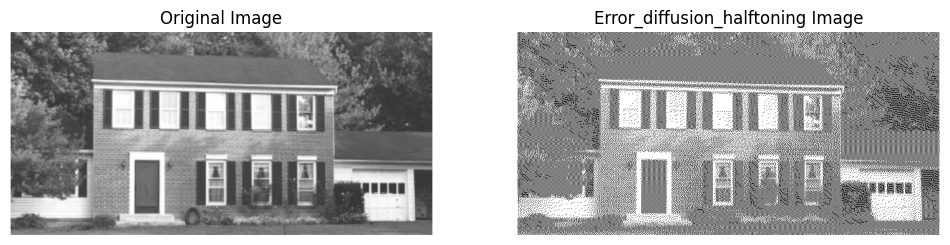

In [82]:
def error_diffusion_halftoning(image_path, threshold=128):
    
    # convert to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=np.float32)  # Convert to float for error calculations

    # Get image dimensions
    height, width = img_array.shape

    # Create copies for error propagation and halftone output
    Ep = np.zeros_like(img_array, dtype=np.float32)  # Error propagation matrix
    Eg = np.zeros_like(img_array, dtype=np.float32)  # Error generated matrix
    halftone = np.zeros_like(img_array, dtype=np.uint8)  # Halftoned output image

    # Error distribution coefficients (Floyd-Steinberg)
    diffusion_kernel = {
        (0, 1): 7 / 16,
        (1, -1): 3 / 16,
        (1, 0): 5 / 16,
        (1, 1): 1 / 16
    }

    # Loop over each pixel in the image
    for m in range(height):
        for n in range(width):
            # Calculate the total propagated error at (m, n)
            T = img_array[m, n] + Ep[m, n]

            # Thresholding and determining pixel value
            if T > threshold:
                halftone[m, n] = 255  # Set pixel on
                Eg[m, n] = T - 2 * threshold  # Calculate error generated
            else:
                halftone[m, n] = 0    # Set pixel off
                Eg[m, n] = threshold   # Calculate error generated

            # Propagate the error to the neighboring pixels
            for (dy, dx), fraction in diffusion_kernel.items():
                ny, nx = m + dy, n + dx
                if 0 <= ny < height and 0 <= nx < width:
                    Ep[ny, nx] += Eg[m, n] * fraction

    # Convert the result back to an image
    return Image.fromarray(halftone)

# Example usage
halftoned_image = error_diffusion_halftoning(IMAGE_PATH)

# Display the original and binary images side by side
original_img = Image.open(IMAGE_PATH)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Thresholded binary image
plt.subplot(1, 2, 2)
plt.imshow(halftoned_image, cmap="gray")
plt.title("Error_diffusion_halftoning Image")
plt.axis("off")

plt.show()

## C) Histogram & Histogram Equalization

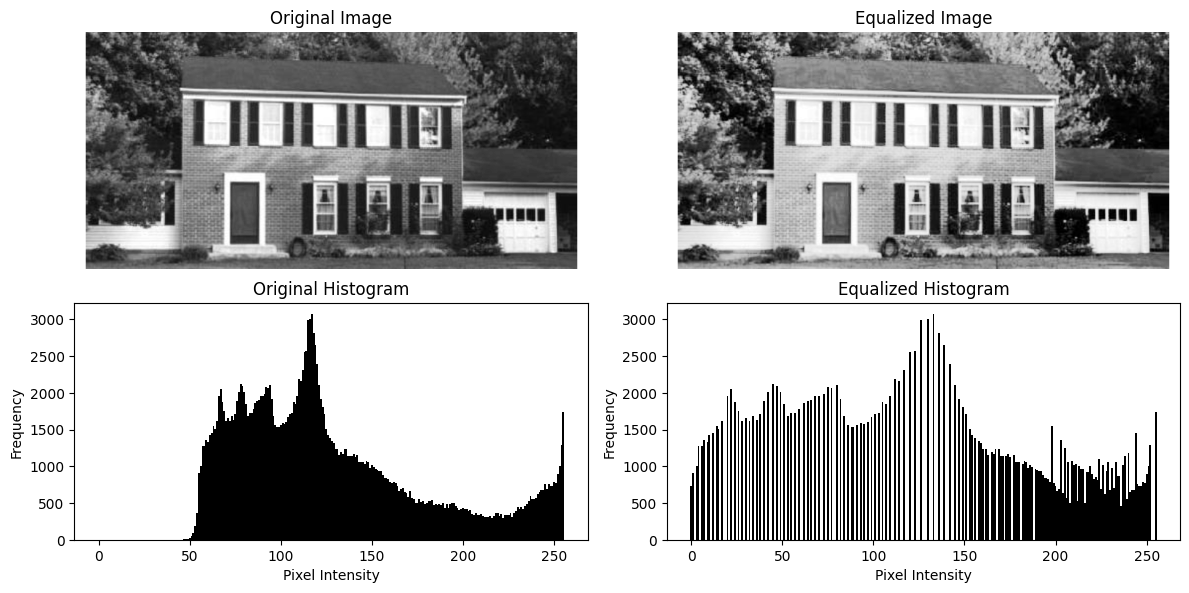

In [83]:
def compute_histogram(image_array):
    
    histogram = [0] * 256  
    for pixel in image_array.flatten():
        histogram[pixel] += 1  
    
    return histogram

def compute_cdf(histogram):
    
    cdf = [0] * len(histogram)
    cdf[0] = histogram[0]
    for i in range(1, len(histogram)):
        cdf[i] = cdf[i - 1] + histogram[i]
    return cdf

def normalize_cdf(cdf, total_pixels):
    
    cdf_min = min(value for value in cdf if value > 0)  # Avoid divide-by-zero
    cdf_normalized = [(value - cdf_min) * 255 // (total_pixels - cdf_min) for value in cdf]
    return cdf_normalized

def apply_histogram_equalization(image_array, cdf_normalized):
    """
    Apply the equalized CDF to the image.
    """
    equalized_array = np.zeros_like(image_array)
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            equalized_array[i, j] = cdf_normalized[image_array[i, j]]
    return equalized_array

def histogram_equalization_manual(image_path):
    # Step 1: Load the image and convert to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    # Step 2: Compute the histogram
    histogram = compute_histogram(img_array)

    # Step 3: Compute the CDF
    cdf = compute_cdf(histogram)

    # Step 4: Normalize the CDF to [0, 255]
    total_pixels = img_array.size
    cdf_normalized = normalize_cdf(cdf, total_pixels)

    # Step 5: Apply the CDF to equalize the image
    equalized_array = apply_histogram_equalization(img_array, cdf_normalized)

    # Convert the equalized array back to an image
    equalized_img = Image.fromarray(equalized_array.astype(np.uint8))
    return  img,equalized_img, histogram, compute_histogram(equalized_array)

# Example usage
#image_path = "Screenshot 2024-11-26 195719.png"  # Replace with your image path
original_image, equalized_image, original_histogram, equalized_histogram = histogram_equalization_manual(IMAGE_PATH)


# Display images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Equalized image
plt.subplot(2, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')

# Original histogram
plt.subplot(2, 2, 3)
plt.bar(range(256), original_histogram, color='black', width=1)
plt.title("Original Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Equalized histogram
plt.subplot(2, 2, 4)
plt.bar(range(256), equalized_histogram, color='black', width=1)
plt.title("Equalized Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## D)Simple Edge Detection Methods

## 1)Sobel Operator

In [84]:
def apply_kernel(image, kernel):
    
    kernel_height, kernel_width = kernel.shape
    img_height, img_width = image.shape

    # Output image
    result = np.zeros((img_height - kernel_height + 1, img_width - kernel_width + 1))

    # Convolve the kernel over the image
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            region = image[i:i + kernel_height, j:j + kernel_width]
            result[i, j] = np.sum(region * kernel)

    return result


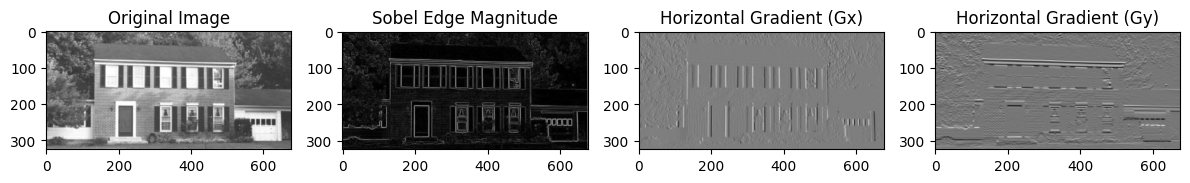

In [85]:
def sobel_operator(image_path):
    
    # Sobel kernels
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])

    # Load and convert the image to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=float)  # Convert to float for gradient calculations

    # Apply Sobel kernels
    grad_x = apply_kernel(img_array, sobel_x)
    grad_y = apply_kernel(img_array, sobel_y)

    # Compute gradient magnitude
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_magnitude = (grad_magnitude / grad_magnitude.max()) * 255  # Normalize to 0-255

    # Convert to an image
    grad_image = Image.fromarray(grad_magnitude.astype(np.uint8))

    return grad_image, grad_x, grad_y

sobel_image, grad_x, grad_y = sobel_operator(IMAGE_PATH)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(Image.open(IMAGE_PATH), cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Sobel Edge Magnitude")
plt.imshow(sobel_image, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Horizontal Gradient (Gx)")
plt.imshow(grad_x, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Horizontal Gradient (Gy)")
plt.imshow(grad_y, cmap='gray')

plt.tight_layout()
plt.show()


## 2) Prewitt Operator

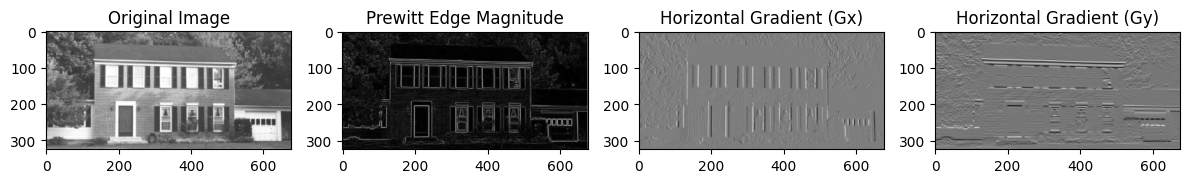

In [86]:
def prewitt_operator(image_path):
    
    # Prewitt kernels
    prewitt_x = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]])
    prewitt_y = np.array([[-1, -1, -1],
                          [ 0,  0,  0],
                          [ 1,  1,  1]])

    # Load and convert the image to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=float)  # Convert to float for gradient calculations

    # Apply Prewitt kernels
    grad_x = apply_kernel(img_array, prewitt_x)
    grad_y = apply_kernel(img_array, prewitt_y)

    # Compute gradient magnitude
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_magnitude = (grad_magnitude / grad_magnitude.max()) * 255  # Normalize to 0-255

    # Convert to an image
    grad_image = Image.fromarray(grad_magnitude.astype(np.uint8))

    return grad_image, grad_x, grad_y


prewitt_image, grad_x, grad_y = prewitt_operator(IMAGE_PATH)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(Image.open(IMAGE_PATH), cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Prewitt Edge Magnitude")
plt.imshow(prewitt_image, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Horizontal Gradient (Gx)")
plt.imshow(grad_x, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Horizontal Gradient (Gy)")
plt.imshow(grad_y, cmap='gray')

plt.tight_layout()
plt.show()


## 3) Kirsch Operator

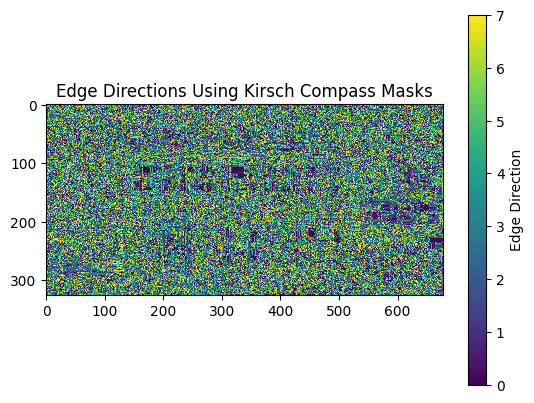

In [87]:
def apply_kirsch_masks(image):
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Kirsch masks (8 compass directions)
    kirsch_masks = [
        np.array([[-3, -3, -3],
                  [-3,  0, -3],
                  [ 5,  5,  5]]),  # North
        np.array([[-3, -3, -3],
                  [5,  0,  -3],
                  [5,  5,  -3]]),  # North-East
        np.array([[5, -3,  -3],
                   [5,  0,  -3],
                   [5, -3,  -3]]),  # East
        np.array([[5,  5,  -3],
                [5,  0,  -3],
                [-3, -3, -3]]),  # South-East
        np.array([[ 5,  5,  5],
                [-3,  0, -3],
                [-3, -3, -3]]),  # South
        np.array([[ -3,  5, 5],
                [ -3,  0, 5],
                [-3, -3, -3]]),  # South-West
        np.array([[ -3, -3, 5],
                [ -3,  0, 5],
                [ -3, -3, 5]]),  # West
        np.array([[-3, -3, -3],
                [ -3,  0, 5],
                [ -3,  5, 5]])   # North-West
    ]

    # Pad the image to handle borders
    padded_image = np.pad(image, 1, mode='constant', constant_values=0)
    
    # Initialize an array to store the edge response in each direction
    edge_responses = np.zeros((8, image.shape[0], image.shape[1]))
    
    # Apply each Kirsch mask to the image
    for i, mask in enumerate(kirsch_masks):
        response = np.zeros_like(image)
        
        # Convolve the mask with the image (manual implementation)
        for row in range(1, padded_image.shape[0] - 1):
            for col in range(1, padded_image.shape[1] - 1):
                region = padded_image[row-1:row+2, col-1:col+2]
                response[row-1, col-1] = np.sum(region * mask)
        
        edge_responses[i] = response
    
    # Find the maximum edge response for each pixel and its corresponding direction
    edge_direction = np.argmax(edge_responses, axis=0)

    return edge_direction

# Function to display edge directions
def display_edge_directions(edge_direction):
    # Create a colormap for visualization
    plt.imshow(edge_direction, interpolation='nearest')
    plt.colorbar(label='Edge Direction')
    plt.title("Edge Directions Using Kirsch Compass Masks")
    plt.show()


# Apply Kirsch masks and get the edge direction
edge_direction = apply_kirsch_masks(cv2.imread(IMAGE_PATH))

# Display the edge direction image
display_edge_directions(edge_direction)


## E) Advanced Edge Detection

## Homogeneity

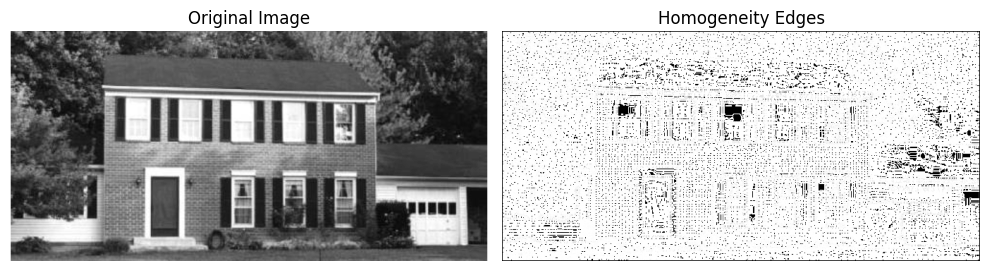

In [88]:
def homogeneity_function(image, threshold=4):
    
    height, width = image.shape
    homogeneity_image = np.zeros_like(image)  
    
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            center_pixel = image[i, j]
            
            # Compute absolute differences with neighbors
            neighbors = [
                image[i-1, j-1], image[i-1, j], image[i-1, j+1], 
                image[i, j-1], image[i, j+1], 
                image[i+1, j-1], image[i+1, j], image[i+1, j+1]
            ]
            
            # Compute the maximum difference (homogeneity value)
            homogeneity_value = max(abs(center_pixel - np.array(neighbors)))
            homogeneity_image[i, j] = homogeneity_value
            homogeneity_image[i, j] = np.where(homogeneity_image[i, j]>=threshold,homogeneity_image[i, j],0)
            
    
    return homogeneity_image

# Load an example grayscale image
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the homogeneity function
edges = homogeneity_function(image, threshold=50)

# Display the original and processed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

# Homogeneity Image
plt.subplot(1, 2, 2)
plt.title('Homogeneity Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\750978968.py:12: RuntimeWarning: overflow encountered in scalar subtract
  diff_2 = abs(image[i-1,j+1] - image[i+1,j-1])
C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\750978968.py:13: RuntimeWarning: overflow encountered in scalar subtract
  diff_3 = abs(image[i,j-1] - image[i,j+1])
C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\750978968.py:11: RuntimeWarning: overflow encountered in scalar subtract
  diff_1 = abs(image[i-1,j-1] - image[i+1,j+1])
C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\750978968.py:14: RuntimeWarning: overflow encountered in scalar subtract
  diff_4 = abs(image[i-1,j] - image[i+1,j])


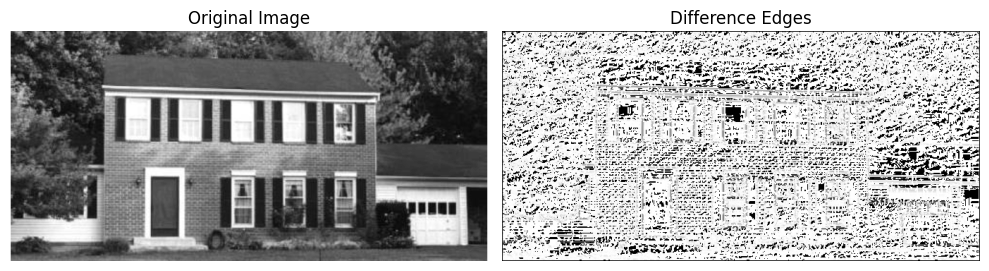

In [89]:
def difference_operator(image, threshold):
    height, width = image.shape
    diff_image = np.zeros_like(image)  
    
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            center_pixel = image[i, j]
            
            # Compute absolute differences with neighbors
            diff_1 = abs(image[i-1,j-1] - image[i+1,j+1])
            diff_2 = abs(image[i-1,j+1] - image[i+1,j-1])
            diff_3 = abs(image[i,j-1] - image[i,j+1])
            diff_4 = abs(image[i-1,j] - image[i+1,j])
            
            # Compute the maximum difference (homogeneity value)
            max_num = max(diff_1, diff_2, diff_3, diff_4)
            diff_image[i,j] = max_num
    
    # Apply thresholding to the entire image (outside of the loop)
    diff_image = np.where(diff_image >= threshold, diff_image, 0)
    
    return diff_image

# Load an example grayscale image
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the homogeneity function
edges = difference_operator(image, threshold=50)

# Display the original and processed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

# Homogeneity Image
plt.subplot(1, 2, 2)
plt.title('Difference Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [90]:
# 7x7 mask
mask_7x7 = np.array([
    [0, 0, -1, -1, -1, 0, 0],
    [0, -2, -3, -3, -3, -2, 0],
    [-1, -3, 5, 5, 5, -3, -1],
    [-1, -3, 5, 16, 5, -3, -1],
    [-1, -3, 5, 5, 5, -3, -1],
    [0, -2, -3, -3, -3, -2, 0],
    [0, 0, -1, -1, -1, 0, 0]
], dtype=np.float32)

# 9x9 mask
mask_9x9 = np.array([
    [0, 0, 0, -1, -1, -1, 0, 0, 0,],
[0, -2, -3, -3, -3, -3, -3, -2, 0],
[0, -3, -2, -1, -1, -1, -2, -3, 0],
[-1, -3, -1, 9, 9, 9, -1, -3, -1],
[-1, -3, -1, 9, 19, 9, -1, -3, -1],
[-1, -3, -1, 9, 9, 9, -1, -3, -1],
[0, -3, -2, -1, -1, -1, -2, -3, 0],
[0, -2, -3, -3, -3, -3, -3, -2, 0],
[0, 0, 0, -1, -1, -1, 0, 0, 0]
], dtype=np.float32)

## Difference of Gaussian

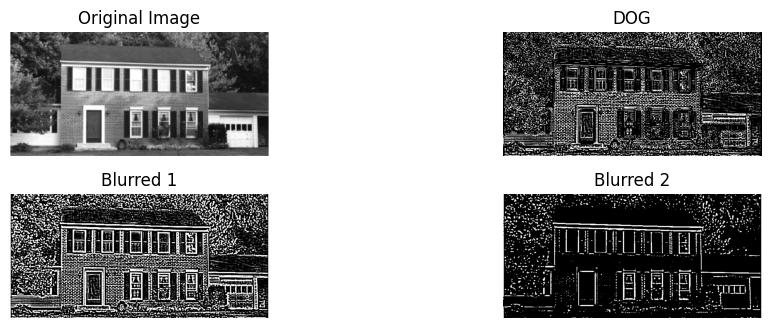

In [91]:
def difference_gaussian(image,mask_1,mask_2):
    blurred_1 = cv2.filter2D(image,-1,mask_1)
    blurred_2 = cv2.filter2D(image,-1,mask_2)
    result= blurred_1 - blurred_2
    return result,blurred_1,blurred_2



# Load an example grayscale image
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the Difference function
res,b_1,b_2 = difference_gaussian(image,mask_7x7,mask_9x9)

# Display the original and processed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(3, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

# DOG Image (assuming 'res' is the DOG result)
plt.subplot(3, 2, 2)
plt.title('DOG')
plt.imshow(res, cmap='gray')
plt.axis('off')

# Homogeneity Edges Image (first one)
plt.subplot(3, 2, 3)
plt.title('Blurred 1')
plt.imshow(b_1, cmap='gray')
plt.axis('off')

# Homogeneity Edges Image (second one)
plt.subplot(3, 2, 4)
plt.title('Blurred 2')
plt.imshow(b_2, cmap='gray')
plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()



## Contrast Filter

In [92]:
edge_mask = np.array([[-1, 0, -1],
[0,  4, 0],
[-1, 0, -1]], dtype=np.float32)

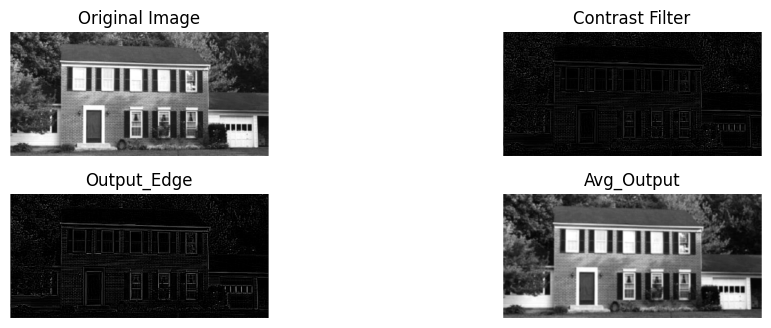

In [93]:
def contrast_filter(image):
    mask = edge_mask
    smoothing_mask = np.ones((3,3)) / 9
    output_edge = cv2.filter2D(image,-1,mask)
    avg_output = cv2.filter2D(image,-1,smoothing_mask).astype(float)
    avg_output += 1e-5
    contrast_img = output_edge / avg_output
    return contrast_img,output_edge,avg_output



# Load an example grayscale image
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the Contrast function
res_2,edg_out,avg_out = contrast_filter(image)

# Display the original and processed images
plt.figure(figsize=(10, 5))


# Original Image
plt.subplot(3, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

# DOG Image (assuming 'res' is the DOG result)
plt.subplot(3, 2, 2)
plt.title('Contrast Filter')
plt.imshow(res_2, cmap='gray')
plt.axis('off')

# Homogeneity Edges Image (first one)
plt.subplot(3, 2, 3)
plt.title('Output_Edge')
plt.imshow(edg_out, cmap='gray')
plt.axis('off')

# Homogeneity Edges Image (second one)
plt.subplot(3, 2, 4)
plt.title('Avg_Output')
plt.imshow(avg_out, cmap='gray')
plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()
    
    

## Variance Mask

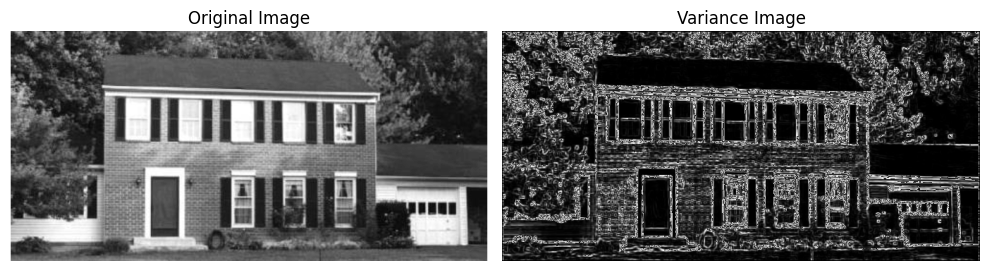

In [94]:
def variance_mask(image):
    output_image = np.zeros_like(image)
    h, w = image.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            neighborhood = image[i-1:i+2, j-1:j+2]
            mean = np.mean(neighborhood)
            var = np.sum((neighborhood - mean) ** 2) / 9
            output_image[i, j] = var
    return output_image

image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the Contrast function
var_img = variance_mask(image)

# Display the original and processed images
plt.figure(figsize=(10, 5))


# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')   

# Original Image
plt.subplot(1, 2, 2)
plt.title('Variance Image')
plt.imshow(var_img, cmap='gray')
plt.axis('off') 


# Adjust layout
plt.tight_layout()
plt.show()
    

## Range Mask

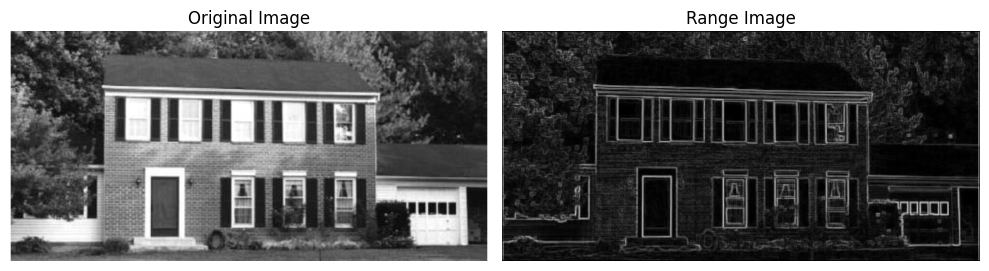

In [95]:
def range_mask(image):
    output_image = np.zeros_like(image)
    h, w = image.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            neighborhood = image[i-1:i+2, j-1:j+2]
            range_v = np.max(neighborhood) - np.min(neighborhood)
            output_image[i,j] = range_v
    return output_image


image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the Range function
range_img = range_mask(image)

# Display the original and processed images
plt.figure(figsize=(10, 5))


# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')   

# Original Image
plt.subplot(1, 2, 2)
plt.title('Range Image')
plt.imshow(range_img, cmap='gray')
plt.axis('off') 


# Adjust layout
plt.tight_layout()
plt.show()
    
    

## Median Mask

In [96]:
high_pass_mask = np.array([[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]], dtype=np.float32)


low_pass_mask = np.array([[0, 1/6, 0],
[1/6, 2/6, 1/6],
[0, 1/6, 0]], dtype=np.float32)




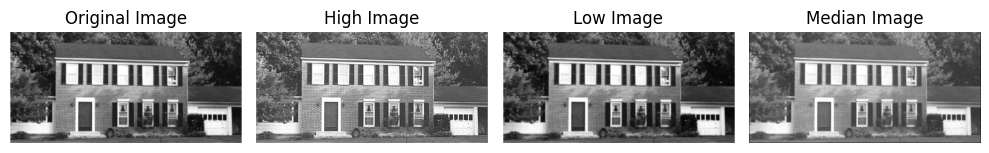

In [97]:
def apply_mask(image,mask):
    output_image = cv2.filter2D(image, -1,mask)
    return output_image


def median_mask(image):
    output_image = np.zeros_like(image)
    h, w = image.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            neighborhood = image[i-1:i+2, j-1:j+2]
            img = np.median(neighborhood)
            output_image[i,j] = img
    return output_image




image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply the homogeneity function
high_img = apply_mask(image,high_pass_mask)
low_img = apply_mask(image,low_pass_mask)
median_img = median_mask(image)


# Display the original and processed images
plt.figure(figsize=(10, 5))


# Original Image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')   

# Original Image
plt.subplot(1, 4, 2)
plt.title('High Image')
plt.imshow(high_img, cmap='gray')
plt.axis('off') 


# Original Image
plt.subplot(1, 4, 3)
plt.title('Low Image')
plt.imshow(low_img, cmap='gray')
plt.axis('off') 



# Original Image
plt.subplot(1, 4, 4)
plt.title('Median Image')
plt.imshow(median_img, cmap='gray')
plt.axis('off') 


# Adjust layout
plt.tight_layout()
plt.show()


## ADD Images

C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\3064956703.py:12: RuntimeWarning: overflow encountered in scalar add
  new_img[i, j] = max(0, min(img1[i, j] + img2_resized[i, j], 255))


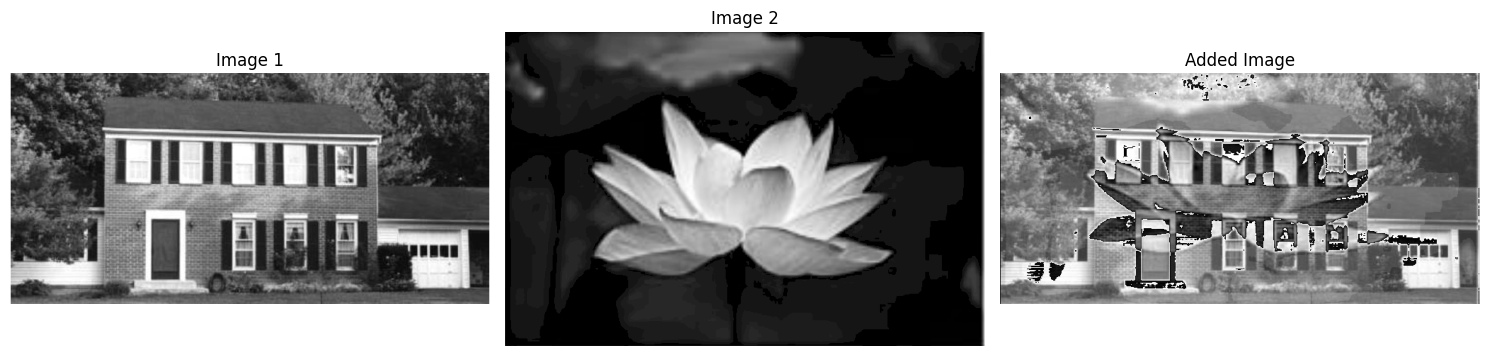

In [98]:
def add_images(img1, img2):
    
    # Ensure both images are of the same size by resizing img2 to match img1
    img2_resized = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    height, width = img1.shape
    new_img = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            # Add pixel values and clamp between 0 and 255
            new_img[i, j] = max(0, min(img1[i, j] + img2_resized[i, j], 255))
    
    return new_img

# Load the images as grayscale
img1 = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(IMAGE_PATH_2, cv2.IMREAD_GRAYSCALE)

# Ensure images are loaded
if img1 is None or img2 is None:
    raise FileNotFoundError("One or both image files could not be loaded. Check the file paths.")

# Call the function to add images
result_image = add_images(img1, img2)

# Display the result
plt.figure(figsize=(15, 5))

# Original Image 1
plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(img1, cmap='gray')
plt.axis('off')

# Original Image 2
plt.subplot(1, 3, 2)
plt.title('Image 2')
plt.imshow(img2, cmap='gray')
plt.axis('off')

# Resultant Image
plt.subplot(1, 3, 3)
plt.title('Added Image')
plt.imshow(result_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Subtracted Images

C:\Users\I.tech\AppData\Local\Temp\ipykernel_10444\1363830164.py:12: RuntimeWarning: overflow encountered in scalar subtract
  new_img[i, j] = max(0, min(img1[i, j] - img2_resized[i, j], 255))


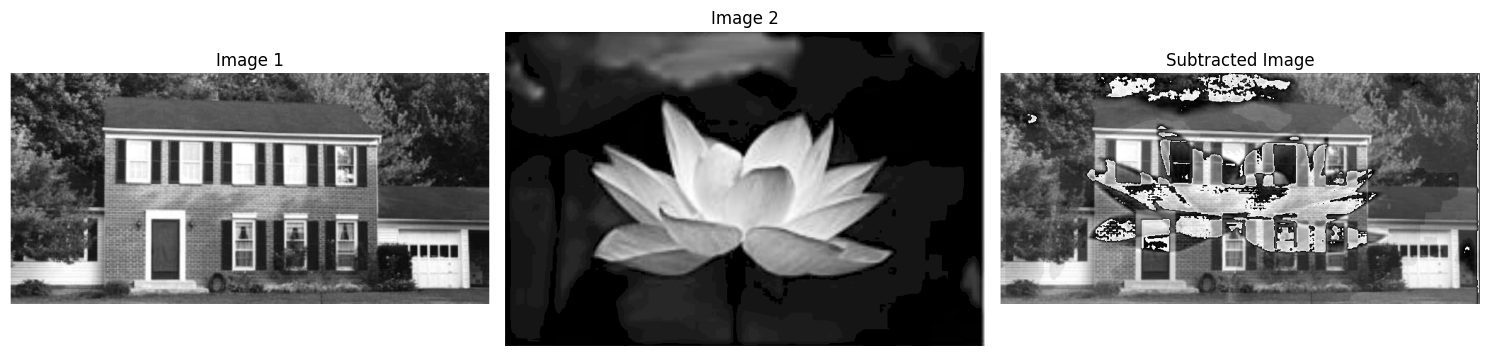

In [99]:
def sub_images(img1, img2):
    
    # Ensure both images are of the same size by resizing img2 to match img1
    img2_resized = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    height, width = img1.shape
    new_img = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            # Add pixel values and clamp between 0 and 255
            new_img[i, j] = max(0, min(img1[i, j] - img2_resized[i, j], 255))
    
    return new_img

# Load the images as grayscale
img1 = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(IMAGE_PATH_2, cv2.IMREAD_GRAYSCALE)

# Ensure images are loaded
if img1 is None or img2 is None:
    raise FileNotFoundError("One or both image files could not be loaded. Check the file paths.")

# Call the function to SUB images
result_image_2 = sub_images(img1, img2)

# Display the result
plt.figure(figsize=(15, 5))

# Original Image 1
plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(img1, cmap='gray')
plt.axis('off')

# Original Image 2
plt.subplot(1, 3, 2)
plt.title('Image 2')
plt.imshow(img2, cmap='gray')
plt.axis('off')

# Resultant Image
plt.subplot(1, 3, 3)
plt.title('Subtracted Image')
plt.imshow(result_image_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Inverted Images

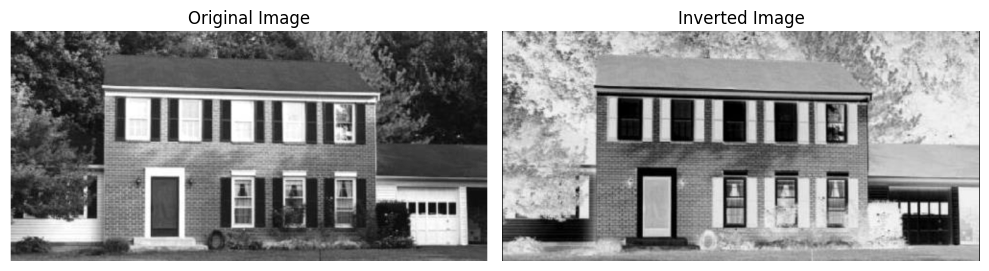

In [100]:
def invert_image(image):
    
    height, width = image.shape
    inverted_img = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            # Invert pixel value
            inverted_img[i, j] = 255 - image[i, j]
    
    return inverted_img

# Load the image as grayscale
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded
if img is None:
    raise FileNotFoundError("Image file could not be loaded. Check the file path.")

# Invert the image
inverted_image = invert_image(img)

# Display the result
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

# Inverted Image
plt.subplot(1, 2, 2)
plt.title('Inverted Image')
plt.imshow(inverted_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Cut & Paste

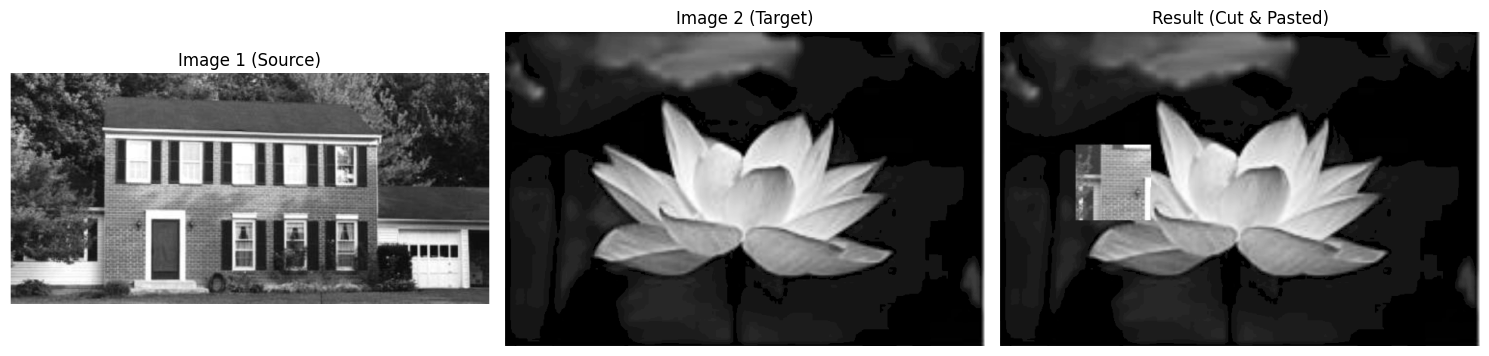

In [101]:
def cut_paste_img(img1, img2, position, size):
    
    x, y = position
    w, h = size
    
    # Extract the cut region from img1
    cut_img = img1[y:y+h, x:x+w]
    
    # Ensure the region fits within img2 dimensions
    new_img = np.copy(img2)
    if y + h <= img2.shape[0] and x + w <= img2.shape[1]:
        new_img[y:y+h, x:x+w] = cut_img
    else:
        raise ValueError("Cut region exceeds target image dimensions.")
    
    return new_img

# Define cut-and-paste parameters
cut_pos = (100, 150)  # Top-left corner for the cut
cut_size = (100, 100)  # Width and height of the cut region

# Load images as grayscale
img1 = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(IMAGE_PATH_2, cv2.IMREAD_GRAYSCALE)

# Ensure images are loaded
if img1 is None or img2 is None:
    raise FileNotFoundError("One or both image files could not be loaded. Check the file paths.")

# Perform cut-and-paste
result_img = cut_paste_img(img1, img2, cut_pos, cut_size)

# Display the results
plt.figure(figsize=(15, 5))

# Image 1 (Source)
plt.subplot(1, 3, 1)
plt.title('Image 1 (Source)')
plt.imshow(img1, cmap='gray')
plt.axis('off')

# Image 2 (Target)
plt.subplot(1, 3, 2)
plt.title('Image 2 (Target)')
plt.imshow(img2, cmap='gray')
plt.axis('off')

# Resulting Image
plt.subplot(1, 3, 3)
plt.title('Result (Cut & Pasted)')
plt.imshow(result_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Segmentation

Enter Low & High Threshold (separated by a space):  100 200


Low Threshold: 100, High Threshold: 200


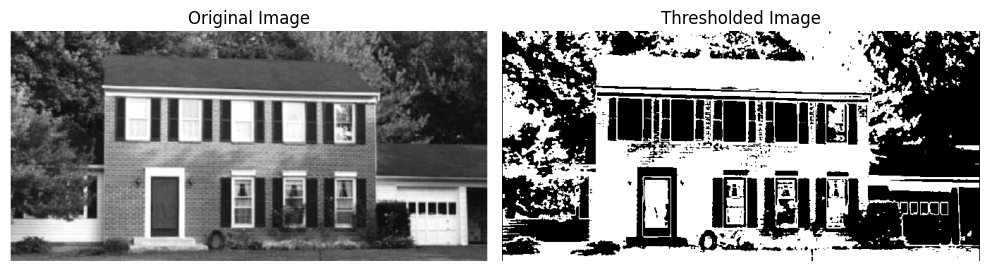

In [102]:
def manual_thresholding(image, low, high):
    

    # Create an output image for thresholding
    output_image = np.zeros_like(image)

    # Apply thresholding
    output_image = ((image > low) & (image < high)).astype(np.uint8) * 255


    

    return output_image

# Load a grayscale image
grayscale_image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Define thresholds
low, high = map(int, input("Enter Low & High Threshold (separated by a space): ").split())

print(f"Low Threshold: {low}, High Threshold: {high}")


# Apply manual thresholding
thresholded_img = manual_thresholding(
        grayscale_image, low,high
)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Thresholded Image")
plt.imshow(thresholded_img, cmap="gray")
plt.axis("off")



plt.tight_layout()
plt.show()


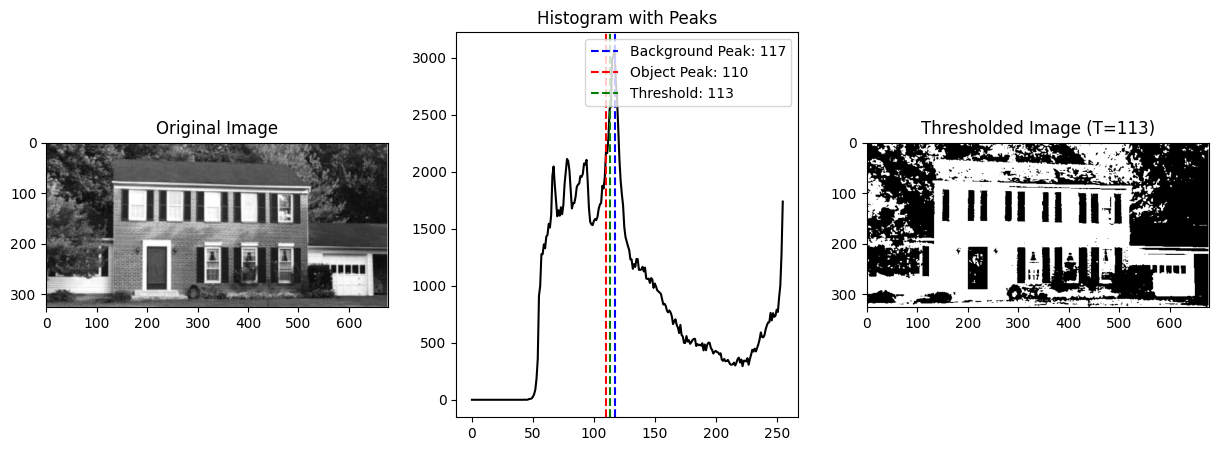

In [103]:
def histogram_peak_thresholding(image):
    
    # Step 1: Compute Histogram
    histogram = np.zeros(256, dtype=int)
    for pixel in image.ravel():  # Flatten the image into a 1D array
        histogram[pixel] += 1

    # Step 2: Find Peaks in Histogram
    peaks = []
    for i in range(1, len(histogram) - 1):
        if histogram[i] > histogram[i - 1] and histogram[i] > histogram[i + 1]:
            peaks.append(i)

    # Step 3: Sort Peaks
    peaks = sorted(peaks, key=lambda x: histogram[x], reverse=True)

    # Step 4: Select Background and Object Peaks
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in histogram!")
    background_peak = peaks[0]
    object_peak = peaks[1]

    # Step 5: Calculate Threshold
    threshold = (background_peak + object_peak) // 2

    # Step 6: Apply Thresholding
    binary_image = ((image > threshold) * 255).astype(np.uint8)

    return binary_image, threshold, histogram, background_peak, object_peak


grayscale_image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply histogram peak thresholding
thresholded_img, threshold, histogram, bg_peak, obj_peak = histogram_peak_thresholding(grayscale_image)

# Plot results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(grayscale_image, cmap="gray")

# Histogram
plt.subplot(1, 3, 2)
plt.title("Histogram with Peaks")
plt.plot(histogram, color="black")
plt.axvline(x=bg_peak, color="blue", linestyle="--", label=f"Background Peak: {bg_peak}")
plt.axvline(x=obj_peak, color="red", linestyle="--", label=f"Object Peak: {obj_peak}")
plt.axvline(x=threshold, color="green", linestyle="--", label=f"Threshold: {threshold}")
plt.legend()

# Thresholded Image
plt.subplot(1, 3, 3)
plt.title(f"Thresholded Image (T={threshold})")
plt.imshow(thresholded_img, cmap="gray")

plt.show()


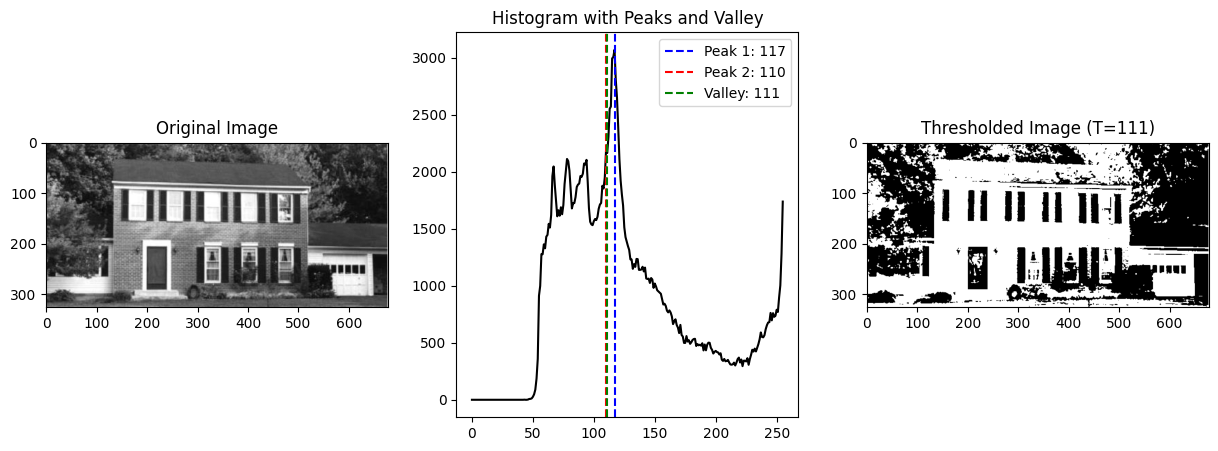

In [104]:
def histogram_valley_thresholding(image):
    
    # Step 1: Calculate Histogram
    histogram = np.zeros(256, dtype=int)
    for pixel in image.ravel():
        histogram[pixel] += 1

    # Step 2: Detect Peaks in the Histogram
    peaks = []
    for i in range(1, len(histogram) - 1):
        if histogram[i] > histogram[i - 1] and histogram[i] > histogram[i + 1]:
            peaks.append(i)

    # Step 3: Sort Peaks by Prominence
    peaks = sorted(peaks, key=lambda x: histogram[x], reverse=True)
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in histogram!")

    # Select the two most prominent peaks
    peak1, peak2 = peaks[:2]

    # Step 4: Find the Valley Between Peaks
    start, end = min(peak1, peak2), max(peak1, peak2)
    valley = np.argmin(histogram[start:end + 1]) + start

    # Step 5: Segment the Image
    binary_image = ((image > valley) * 255).astype(np.uint8)

    return binary_image, valley, histogram, peak1, peak2


grayscale_image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply Histogram Valley Thresholding
thresholded_img, valley, histogram, peak1, peak2 = histogram_valley_thresholding(grayscale_image)

# Plot results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(grayscale_image, cmap="gray")

# Histogram
plt.subplot(1, 3, 2)
plt.title("Histogram with Peaks and Valley")
plt.plot(histogram, color="black")
plt.axvline(x=peak1, color="blue", linestyle="--", label=f"Peak 1: {peak1}")
plt.axvline(x=peak2, color="red", linestyle="--", label=f"Peak 2: {peak2}")
plt.axvline(x=valley, color="green", linestyle="--", label=f"Valley: {valley}")
plt.legend()

# Thresholded Image
plt.subplot(1, 3, 3)
plt.title(f"Thresholded Image (T={valley})")
plt.imshow(thresholded_img, cmap="gray")

plt.show()


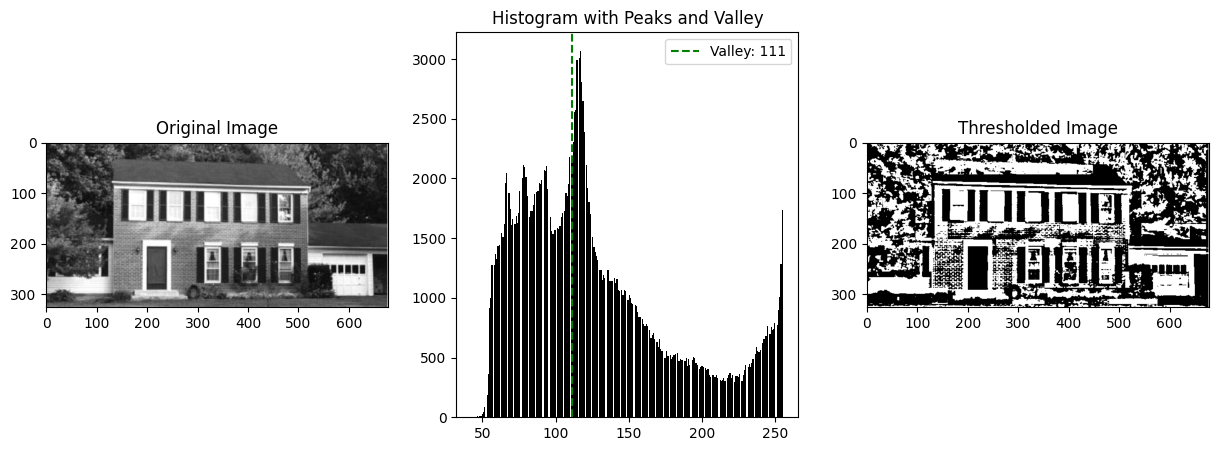

In [105]:
def adaptive_histogram_thresholding(image, region_size=32):
    
    height, width = image.shape
    thresholded_image = np.zeros_like(image)

    # Step 1: Calculate Histogram (global histogram)
    histogram = np.zeros(256, dtype=int)
    for pixel in image.ravel():
        histogram[pixel] += 1

    # Step 2: Detect Peaks in the Histogram
    peaks = []
    for i in range(1, len(histogram) - 1):
        if histogram[i] > histogram[i - 1] and histogram[i] > histogram[i + 1]:
            peaks.append(i)

    # Step 3: Sort Peaks by Prominence
    peaks = sorted(peaks, key=lambda x: histogram[x], reverse=True)
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in histogram!")
    
    peak1, peak2 = peaks[:2]

    # Step 4: Find the Valley Between Peaks
    start, end = min(peak1, peak2), max(peak1, peak2)
    valley = np.argmin(histogram[start:end + 1]) + start

    # Step 5: First Pass Segmentation (use valley as threshold)
    binary_image_first_pass = (image > valley) * 255
    
    # Divide the image into sub-regions (smaller regions)
    for i in range(0, height, region_size):
        for j in range(0, width, region_size):
            sub_region = image[i:i+region_size, j:j+region_size]
            sub_histogram = np.zeros(256, dtype=int)
            
            # Step 1: Calculate Histogram for sub-region
            for pixel in sub_region.ravel():
                sub_histogram[pixel] += 1

            # Step 2: Detect Peaks in sub-region histogram
            sub_peaks = []
            for k in range(1, len(sub_histogram) - 1):
                if sub_histogram[k] > sub_histogram[k - 1] and sub_histogram[k] > sub_histogram[k + 1]:
                    sub_peaks.append(k)

            # Step 3: Sort Peaks by Prominence (sort in descending order)
            sub_peaks = sorted(sub_peaks, key=lambda x: sub_histogram[x], reverse=True)
            
            # Step 4: Find the Valley Between Peaks
            if len(sub_peaks) >= 2:
                sub_peak1, sub_peak2 = sub_peaks[:2]
                sub_valley = np.argmin(sub_histogram[min(sub_peak1, sub_peak2):max(sub_peak1, sub_peak2)+1]) + min(sub_peak1, sub_peak2)
            else:
                sub_valley = valley  # Fallback to global valley if not enough peaks found

            # Step 6: Calculate New Threshold from Mean of Segment
            segment_mean = np.mean(sub_region)
            thresholded_image[i:i+region_size, j:j+region_size] = (sub_region > segment_mean) * 255

    # Step 7: Adjust Thresholds Using New Means (adjust using new threshold calculation)
    # Iterate again over sub-regions for the second pass of segmentation
    thresholded_image_second_pass = np.zeros_like(image)
    for i in range(0, height, region_size):
        for j in range(0, width, region_size):
            sub_region = image[i:i+region_size, j:j+region_size]
            sub_mean = np.mean(sub_region)
            thresholded_image_second_pass[i:i+region_size, j:j+region_size] = (sub_region > sub_mean) * 255

    return thresholded_image_second_pass, valley, peaks


grayscale_image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Apply Adaptive Histogram Thresholding
thresholded_img, valley, peaks = adaptive_histogram_thresholding(grayscale_image)

# Plot results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(grayscale_image, cmap="gray")

# Histogram
plt.subplot(1, 3, 2)
plt.title("Histogram with Peaks and Valley")
plt.hist(grayscale_image.ravel(), bins=256, color="black")
plt.axvline(x=valley, color="green", linestyle="--", label=f"Valley: {valley}")
plt.legend()

# Thresholded Image
plt.subplot(1, 3, 3)
plt.title(f"Thresholded Image")
plt.imshow(thresholded_img, cmap="gray")

plt.show()
